0. 구글 드라이브 연동 & 기본 설정

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 시드 고정 (재현성)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 이미지/배치 설정
IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
TARGET_PER_CLASS = 500   # train에서 클래스별 목표 개수

# ★ B-SMOTE 전용 데이터셋 경로
BASE_DIR  = '/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

# train 내 폴더들
normal_train_dir = os.path.join(TRAIN_DIR, 'normal')
type1_train_dir  = os.path.join(TRAIN_DIR, 'type1')
type2_train_dir  = os.path.join(TRAIN_DIR, 'type2')

# B-SMOTE 결과 저장할 폴더
type1_bsmote_dir = os.path.join(TRAIN_DIR, 'type1(BSMOTE)')
type2_bsmote_dir = os.path.join(TRAIN_DIR, 'type2(BSMOTE)')

print("TRAIN_DIR :", TRAIN_DIR)
print("TEST_DIR  :", TEST_DIR)
print("normal_train_dir :", normal_train_dir)
print("type1_train_dir  :", type1_train_dir)
print("type2_train_dir  :", type2_train_dir)
print("type1_bsmote_dir :", type1_bsmote_dir)
print("type2_bsmote_dir :", type2_bsmote_dir)

Mounted at /content/drive
TRAIN_DIR : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train
TEST_DIR  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/test
normal_train_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/normal
type1_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type1
type2_train_dir  : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type2
type1_bsmote_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type1(BSMOTE)
type2_bsmote_dir : /content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type2(BSMOTE)


1.  기존 데이터셋 정보 확인

In [3]:
def get_image_paths(folder):
    if not os.path.exists(folder):
        return []
    paths = []
    for name in os.listdir(folder):
        p = os.path.join(folder, name)
        if not os.path.isfile(p):
            continue
        try:
            with Image.open(p) as im:
                im.verify()
            paths.append(p)
        except Exception:
            # 이미지가 아니면 무시
            pass
    return sorted(paths)

normal_paths_orig = get_image_paths(normal_train_dir)
type1_paths_orig  = get_image_paths(type1_train_dir)
type2_paths_orig  = get_image_paths(type2_train_dir)

print("=== 기존 train 데이터셋(증강 전) ===")
print("normal 개수:", len(normal_paths_orig))
print("type1  개수:", len(type1_paths_orig))
print("type2  개수:", len(type2_paths_orig))

=== 기존 train 데이터셋(증강 전) ===
normal 개수: 500
type1  개수: 25
type2  개수: 25


2. B-SMOTE로 type1, tyoe2 각각 475장 생성

In [4]:
# 2-1. B-SMOTE 함수 정의

def load_images(paths, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    """경로 리스트에서 이미지를 로드해서 [0,1] float32 배열로 반환."""
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        imgs.append(img)
    return np.stack(imgs, axis=0)  # (N, H, W, C)


def borderline_smote_augment(X_min, X_maj, n_new, k=5):

    if n_new <= 0 or X_min.shape[0] < 2:
        return np.empty((0, X_min.shape[1]), dtype=X_min.dtype)

    # 전체 데이터 구성
    X_all = np.vstack([X_min, X_maj])
    y_all = np.concatenate([
        np.ones(X_min.shape[0], dtype=int),  # minority = 1
        np.zeros(X_maj.shape[0], dtype=int)  # majority = 0
    ])

    n_min = X_min.shape[0]

    # k-NN (자기 자신 + k 이웃이므로 k+1 사용)
    k_nn = min(k + 1, X_all.shape[0])
    nbrs = NearestNeighbors(n_neighbors=k_nn)
    nbrs.fit(X_all)
    neighbors = nbrs.kneighbors(X_min, return_distance=False)  # (n_min, k+1)

    # 1) borderline seed 선택
    borderline_indices = []
    for i in range(n_min):
        nn_idx = neighbors[i][1:]  # 첫 번째는 자기 자신이므로 제외
        nn_labels = y_all[nn_idx]
        n_min_neighbors = np.sum(nn_labels == 1)
        n_maj_neighbors = np.sum(nn_labels == 0)

        # minority, majority가 섞여 있는 경우를 borderline 샘플로 간주
        if n_min_neighbors > 0 and n_maj_neighbors > 0:
            borderline_indices.append(i)

    # borderline 샘플이 하나도 없으면, 그냥 일반 SMOTE처럼 전체 minority로 fallback
    if len(borderline_indices) == 0:
        print("[주의] Borderline 샘플이 없어 전체 minority에 대해 일반 SMOTE 방식으로 생성합니다.")
        borderline_indices = list(range(n_min))

    borderline_indices = np.array(borderline_indices, dtype=int)

    # 2) synthetic 샘플 생성
    synthetic = []
    for _ in range(n_new):
        # seed는 borderline 샘플 중에서 선택
        i = random.choice(borderline_indices)
        # seed i의 이웃 중 minority 이웃만 골라서 사용
        nn_idx = neighbors[i][1:]
        nn_minority = [j for j in nn_idx if y_all[j] == 1]

        if len(nn_minority) == 0:
            # minority 이웃이 없다면, 전체 minority 중에서 아무거나 선택
            j = random.randint(0, n_min - 1)
        else:
            # X_all의 index → X_min index로 환산
            j_global = random.choice(nn_minority)
            j = j_global  # j_global < n_min 인 것이 보장됨 (minority니까)
            if j >= n_min:
                # 혹시나 로직 상 문제로 majority가 섞이면 fallback
                j = random.randint(0, n_min - 1)

        lam = random.random()
        new_sample = X_min[i] + lam * (X_min[j] - X_min[i])
        synthetic.append(new_sample)

    return np.stack(synthetic, axis=0)


def save_synthetic_images(synthetic_imgs, target_dir, prefix):
    """
    synthetic_imgs: float32, [0,1], shape = (N, H, W, 3)
    target_dir    : 저장할 폴더 (예: type1(BSMOTE) 폴더)
    prefix        : 파일 이름 접두사 (예: 'bsmote_type1')
    """
    os.makedirs(target_dir, exist_ok=True)
    # 이미 prefix로 시작하는 파일이 있다면, 그 뒤 번호부터 이어서 저장
    existing = get_image_paths(target_dir)
    existing_prefix_count = sum(
        1 for p in existing if os.path.basename(p).startswith(prefix)
    )
    start_idx = existing_prefix_count

    for i, img in enumerate(synthetic_imgs):
        img_uint8 = (img * 255).astype(np.uint8)
        im = Image.fromarray(img_uint8)
        filename = f"{prefix}_{start_idx + i:05d}.png"
        im.save(os.path.join(target_dir, filename))


def augment_class_with_bsmote(orig_dir, bsmote_dir, prefix,
                              normal_paths, target_total=TARGET_PER_CLASS):
    """
    orig_dir   : minority 원본 이미지 폴더 (type1, type2)
    bsmote_dir : B-SMOTE로 생성한 이미지 저장 폴더 (type1(BSMOTE), type2(BSMOTE))
    prefix     : 생성 이미지 파일 이름 접두사 (예: 'bsmote_type1')
    normal_paths: majority 클래스(normal)의 이미지 경로 리스트
    target_total: orig + B-SMOTE 합쳐서 사용하고 싶은 총 개수 (예: 500)

    - orig_dir 안의 원본 개수를 기준으로
      '목표 BSMOTE 개수 = target_total - 원본 개수'를 정확히 맞춘다.
    - 이미 bsmote_dir 안에 이미지가 있으면 그 개수를 고려해서
      부족한 개수만큼만 추가 생성한다.
    """

    orig_paths   = get_image_paths(orig_dir)
    os.makedirs(bsmote_dir, exist_ok=True)
    bsmote_paths = get_image_paths(bsmote_dir)

    n_orig   = len(orig_paths)
    n_bsmote = len(bsmote_paths)

    # 최종적으로 BSMOTE로만 몇 장을 갖고 싶냐? → target_total - 원본 개수
    target_bsmote = target_total - n_orig

    print(f"\n[{orig_dir}]")
    print(f"원본 개수       : {n_orig}")
    print(f"현재 BSMOTE 개수: {n_bsmote}")
    print(f"목표 BSMOTE 개수: {target_bsmote}")

    if target_bsmote <= 0:
        print("이미 원본 개수가 target_total 이상이므로 B-SMOTE 생성 불필요")
        return

    # 이미 BSMOTE가 조금 있어도, 최종적으로 target_bsmote를 맞추도록 부족한 개수 계산
    to_create = target_bsmote - n_bsmote
    if to_create <= 0:
        print("이미 목표 BSMOTE 개수 이상이므로 추가 생성 생략")
        return

    print("이번에 새로 생성할 B-SMOTE 개수:", to_create)

    if n_orig < 2:
        raise ValueError("B-SMOTE를 위해서는 최소 2장 이상의 minority 원본 이미지가 필요합니다.")

    if len(normal_paths) == 0:
        raise ValueError("majority 클래스(normal) 이미지가 없습니다. B-SMOTE를 적용할 수 없습니다.")

    # majority(normal)에서 사용할 샘플 수 제한 (메모리 보호용, 필요시 조정 가능)
    max_maj = min(500, len(normal_paths))
    normal_sample_paths = random.sample(normal_paths, max_maj)
    print("majority(normal) 샘플 사용 개수:", len(normal_sample_paths))

    # minority, majority 이미지 로드
    imgs_min = load_images(orig_paths)             # (N_min, H, W, C)
    imgs_maj = load_images(normal_sample_paths)    # (N_maj, H, W, C)

    X_min = imgs_min.reshape(imgs_min.shape[0], -1)
    X_maj = imgs_maj.reshape(imgs_maj.shape[0], -1)

    # 1차 생성
    synthetic_flat = borderline_smote_augment(X_min, X_maj, n_new=to_create, k=5)
    if synthetic_flat.shape[0] != to_create:
        print(f"[경고] borderline_smote_augment가 요청한 {to_create}개 대신 {synthetic_flat.shape[0]}개만 생성했습니다.")

    synthetic = synthetic_flat.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    synthetic = np.clip(synthetic, 0.0, 1.0)
    save_synthetic_images(synthetic, bsmote_dir, prefix)

    # 생성 후 개수 다시 확인
    bsmote_paths_after = get_image_paths(bsmote_dir)
    n_bsmote_after = len(bsmote_paths_after)
    total_after = n_orig + n_bsmote_after

    print("생성 후 BSMOTE 개수:", n_bsmote_after)
    print("증강 이후 총 개수 (orig + B-SMOTE):", total_after)

    # 혹시라도 뭔가 이유로 target_bsmote에 못 미쳤으면, 부족한 만큼 한 번 더 생성 시도
    remaining = target_bsmote - n_bsmote_after
    if remaining > 0:
        print(f"[추가 생성] 아직 {remaining}장이 부족해서 한 번 더 B-SMOTE 생성합니다.")
        synthetic_flat2 = borderline_smote_augment(X_min, X_maj, n_new=remaining, k=5)
        synthetic2 = synthetic_flat2.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
        synthetic2 = np.clip(synthetic2, 0.0, 1.0)
        save_synthetic_images(synthetic2, bsmote_dir, prefix)

        bsmote_paths_final = get_image_paths(bsmote_dir)
        n_bsmote_final = len(bsmote_paths_final)
        total_final = n_orig + n_bsmote_final

        print("최종 BSMOTE 개수:", n_bsmote_final)
        print("최종 증강 이후 총 개수 (orig + B-SMOTE):", total_final)

In [5]:
# 2-2. Borderline-SMOTE 적용 (type1, type2 각각 475장 생성 → 500장)
augment_class_with_bsmote(
    orig_dir=type1_train_dir,
    bsmote_dir=type1_bsmote_dir,
    prefix="bsmote_type1",
    normal_paths=normal_paths_orig,
    target_total=TARGET_PER_CLASS
)

augment_class_with_bsmote(
    orig_dir=type2_train_dir,
    bsmote_dir=type2_bsmote_dir,
    prefix="bsmote_type2",
    normal_paths=normal_paths_orig,
    target_total=TARGET_PER_CLASS
)

# 증강 결과 확인
type1_orig_paths   = get_image_paths(type1_train_dir)
type1_bsmote_paths = get_image_paths(type1_bsmote_dir)
type2_orig_paths   = get_image_paths(type2_train_dir)
type2_bsmote_paths = get_image_paths(type2_bsmote_dir)

print("\n=== 증강 이후 train 데이터 구조 확인 (B-SMOTE) ===")
print("type1 원본 개수:", len(type1_orig_paths))
print("type1 BSMOTE 개수:", len(type1_bsmote_paths))
print("type1 합계:", len(type1_orig_paths) + len(type1_bsmote_paths))

print("\ntype2 원본 개수:", len(type2_orig_paths))
print("type2 BSMOTE 개수:", len(type2_bsmote_paths))
print("type2 합계:", len(type2_orig_paths) + len(type2_bsmote_paths))


[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type1]
원본 개수       : 25
현재 BSMOTE 개수: 0
목표 BSMOTE 개수: 475
이번에 새로 생성할 B-SMOTE 개수: 475
majority(normal) 샘플 사용 개수: 500
생성 후 BSMOTE 개수: 475
증강 이후 총 개수 (orig + B-SMOTE): 500

[/content/drive/MyDrive/산업공학종합설계2_유빈/Datasets_BSMOTE/train/type2]
원본 개수       : 25
현재 BSMOTE 개수: 0
목표 BSMOTE 개수: 475
이번에 새로 생성할 B-SMOTE 개수: 475
majority(normal) 샘플 사용 개수: 500
생성 후 BSMOTE 개수: 475
증강 이후 총 개수 (orig + B-SMOTE): 500

=== 증강 이후 train 데이터 구조 확인 (B-SMOTE) ===
type1 원본 개수: 25
type1 BSMOTE 개수: 475
type1 합계: 500

type2 원본 개수: 25
type2 BSMOTE 개수: 475
type2 합계: 500


3. 새로 생성된 이미지 예시 확인 (랜덤 10장)

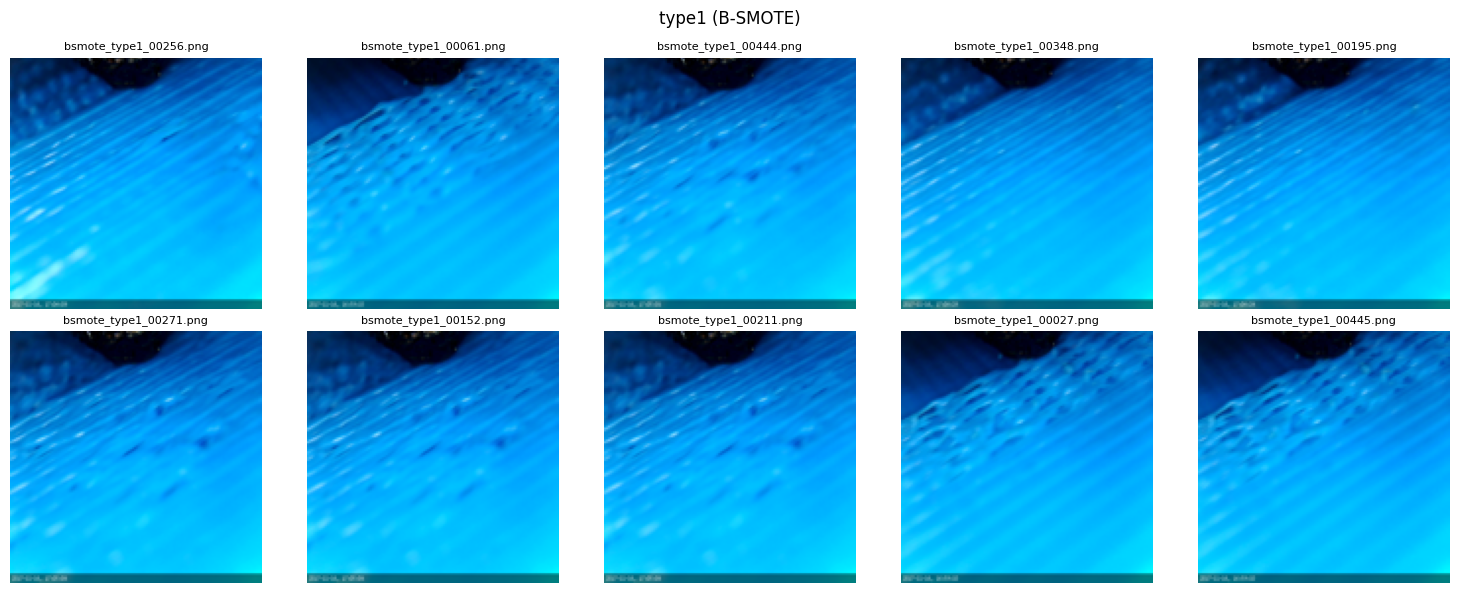

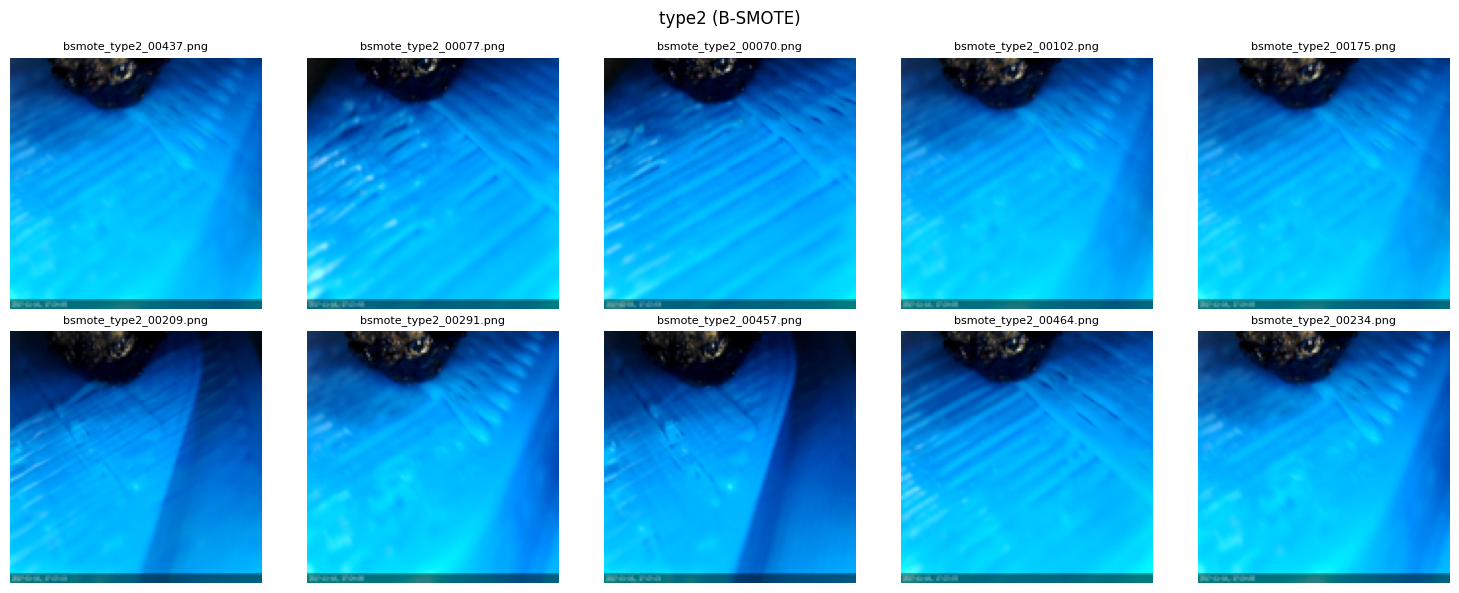

In [6]:
def show_random_images(paths, n=10, title=""):
    sample_paths = random.sample(paths, min(n, len(paths)))
    n_cols = 5
    n_rows = int(np.ceil(len(sample_paths) / n_cols))

    plt.figure(figsize=(n_cols*3, n_rows*3))
    for idx, p in enumerate(sample_paths):
        img = Image.open(p).convert("RGB")
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(p), fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_random_images(type1_bsmote_paths, n=10, title="type1 (B-SMOTE)")
show_random_images(type2_bsmote_paths, n=10, title="type2 (B-SMOTE)")

4. 새로운 데이터셋 (총 1500장) CNN 학습

In [ ]:
# 4-1. 학습에 쓸 경로 / 라벨 구성
# 4-1. 학습에 쓸 경로 / 라벨 구성
CLASS_NAMES = ['normal', 'type1', 'type2']
label_to_index = {name: idx for idx, name in enumerate(CLASS_NAMES)}
print("label_to_index:", label_to_index)

def sample_paths_for_class(base_paths, bsmote_paths=None, max_count=TARGET_PER_CLASS):
    """
    base_paths   : 원본 이미지 경로 리스트
    bsmote_paths : B-SMOTE 이미지 경로 리스트 (없으면 None)
    max_count    : 이 클래스에서 최종 사용할 이미지 수
    """
    all_paths = list(base_paths)
    if bsmote_paths is not None:
        all_paths.extend(bsmote_paths)

    if len(all_paths) < max_count:
        print(f"[경고] 이 클래스에 이미지가 {len(all_paths)}장뿐이라 {max_count}장까지 못 채웁니다.")
        # 있는 만큼만 사용
        return all_paths
    elif len(all_paths) > max_count:
        return random.sample(all_paths, max_count)
    else:
        return all_paths

# normal은 B-SMOTE 안 했다고 가정
normal_paths_for_train = sample_paths_for_class(
    base_paths=normal_paths_orig,
    bsmote_paths=None,
    max_count=TARGET_PER_CLASS
)

type1_paths_for_train = sample_paths_for_class(
    base_paths=type1_orig_paths,
    bsmote_paths=type1_bsmote_paths,
    max_count=TARGET_PER_CLASS
)

type2_paths_for_train = sample_paths_for_class(
    base_paths=type2_orig_paths,
    bsmote_paths=type2_bsmote_paths,
    max_count=TARGET_PER_CLASS
)

print("\n=== 학습에 실제로 사용할 개수 ===")
print("normal:", len(normal_paths_for_train))
print("type1 :", len(type1_paths_for_train))
print("type2 :", len(type2_paths_for_train))

# 전체 train 리스트 + 라벨 만들기
train_paths = (
    normal_paths_for_train +
    type1_paths_for_train +
    type2_paths_for_train
)
train_labels = (
    [label_to_index['normal']] * len(normal_paths_for_train) +
    [label_to_index['type1']]  * len(type1_paths_for_train) +
    [label_to_index['type2']]  * len(type2_paths_for_train)
)

# 섞기
combined = list(zip(train_paths, train_labels))
random.shuffle(combined)
train_paths, train_labels = zip(*combined)
train_paths  = list(train_paths)
train_labels = list(train_labels)

print("\n총 train 샘플 수:", len(train_paths))  # 이상적으로 1500

label_to_index: {'normal': 0, 'type1': 1, 'type2': 2}

=== 학습에 실제로 사용할 개수 ===
normal: 500
type1 : 500
type2 : 500

총 train 샘플 수: 1500


In [ ]:
# 4-2. tf.data 파이프라인 생성
AUTOTUNE = tf.data.AUTOTUNE

def process_path(path, label):
    # 파일 읽기
    img_bytes = tf.io.read_file(path)

    # 이미지 디코딩 (jpg/png 등 자동 인식)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    # rank/shape 명시적으로 지정 (H, W, C)
    img.set_shape([None, None, 3])

    # 크기 변경
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # [0,255] → [0,1] float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, label

# 기본 dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터 증강
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ]
)

def augment(image, label):
    return data_augmentation(image, training=True), label

train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=SEED)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
# 4-3. CNN 모델 정의 & 학습
num_classes = len(CLASS_NAMES)

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5215 - loss: 48.0999
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7311 - loss: 0.5169
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7542 - loss: 0.4786
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8046 - loss: 0.4108
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8442 - loss: 0.3404
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8906 - loss: 0.2773
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9193 - loss: 0.1967
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9226 - loss: 0.2045
Epoch 9/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9369 - loss: 0.1750
Epoch 10/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9415 - loss: 0.1397
Epoch 11/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9466 - loss: 0.1585
Epoch 12/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9721 -

5. test 데이터로 성능 확인

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,          # normal, type1, type2 순서를 train과 맞춤
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# [0,255] → [0,1]
test_ds = test_ds.map(
    lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y),
    num_parallel_calls=AUTOTUNE
)
test_ds = test_ds.prefetch(AUTOTUNE)

# y_true, y_pred 계산
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

Found 300 files belonging to 3 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step
y_true shape: (300,)
y_pred shape: (300,)


6. macro F-score, precision, recall

In [ ]:
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall   : {recall_macro:.4f}")
print(f"Macro F1-score : {f1_macro:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Macro Precision: 0.8459
Macro Recall   : 0.7133
Macro F1-score : 0.6850

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.54      1.00      0.70       100
       type1       1.00      0.27      0.43       100
       type2       1.00      0.87      0.93       100

    accuracy                           0.71       300
   macro avg       0.85      0.71      0.68       300
weighted avg       0.85      0.71      0.68       300



7. Confusion Matrix

Confusion Matrix:
 [[100   0   0]
 [ 73  27   0]
 [ 13   0  87]]


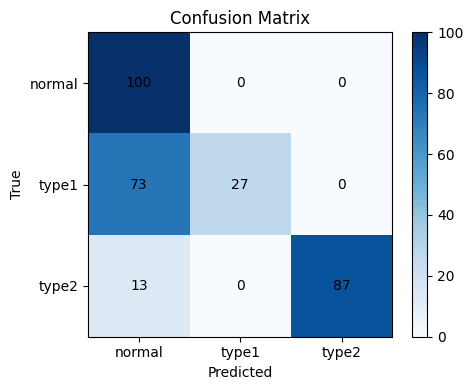

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks(np.arange(len(CLASS_NAMES)))
ax.set_yticks(np.arange(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticklabels(CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black")

plt.title("Confusion Matrix")
plt.colorbar(im)
plt.tight_layout()
plt.show()